# Inroduction to Bayesian Regression

# Gaussian Process Summer School, Melbourne, Australia
### 25th-27th February 2015
### Neil D. Lawrence




### This Notebook

The aim of this notebook is to study Bayesian approaches to regression. As in previous sessions, first extract both the olympic years and the pace of the winning runner into 2-dimensional arrays with the data points in the rows of the array (the first dimension). First let's load in the data.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pods

data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

## The Prior Distribution

In the Bayesian approach, the first thing we do is assume a prior distribution for the parameters, $\mathbf{w}$. In the lectures we took this prior to be 

$$\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \alpha \mathbf{I})$$

In other words, we assumed for the prior that each element of the parameters vector, $w_i$, was drawn from a Gaussian density as follows

$$w_i \sim \mathcal{N}(0,\alpha)$$

Let's start by assigning the parameter of the prior distribution, which is the variance of the prior distribution, $\alpha$.

In [3]:
# set prior variance on w
alpha = 4.
# set the degree of the polynomial basis set
degree = 5
# set the noise variance
sigma2 = 0.01

Now we have the prior variance, we can sample from the prior distribution to see what form we are imposing on the functions *a priori*. To do this, we first sample a weight vector, then we multiply that weight vector by our basis to compute the the functions. Firstly we compute the basis function matrix. We will do it both for our training data, and for a range of prediction locations (`x_pred`). 

In [4]:
num_data = x.shape[0]
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = np.linspace(1890, 2016, num_pred_data)[:, None] # input locations for predictions

now let's build the basis matrices.


In [5]:
def polynomial(x, degree):
    '''Build the polynomial basis matrix with n rows and p columns.'''
    degrees = np.arange(degree+1)
    # python broad casts the 'power' operation to give us a matrix of the right size.
    return x**degrees
 
Phi = polynomial(x, degree)
Phi_pred = polynomial(x_pred, degree)

## Sampling from the Prior

Now we will sample from the prior to produce a vector $\mathbf{w}$ and use it to plot a function which is representative of our belief *before* we fit the data. To do this we are going to use the properties of the Gaussian density and a sample from a *standard normal* using the function `np.random.normal`.

## Scaling Gaussian-distributed Variables

First, let's consider the case where we have one data point and one feature in our basis set. In otherwords $\mathbf{f}$ would be a scalar, $\mathbf{w}$ would be a scalar and $\boldsymbol{\Phi}$ would be a scalar. In this case we have 

$$f = \phi w$$

If $w$ is drawn from a normal density, 

$$w \sim \mathcal{N}(\mu_w,c_w)$$

and $\phi$ is a scalar value which we are given, then properties of the Gaussian density tell us that 

$$\phi w \sim \mathcal{N}(\phi\mu_w,\phi^2c_w)$$

Let's test this out numerically. First we will draw 200 samples from a standard normal,

In [6]:
w_vec = np.random.normal(size=200)

We can compute the mean of these samples and their variance

In [7]:
print 'w sample mean is ', w_vec.mean()
print 'w sample variance is ', w_vec.var()

w sample mean is  -0.0433842939549
w sample variance is  0.897621894937


These are close to zero (the mean) and one (the variance) as you'd expect. Now compute the mean and variance of the scaled version,

In [8]:
phi = 7
f_vec = phi*w_vec
print 'True mean should be phi*0 = 0.'
print 'True variance should be phi*phi*1 = ', phi*phi
print 'f sample mean is ', f_vec.mean()
print 'f sample variance is ', f_vec.var()

True mean should be phi*0 = 0.
True variance should be phi*phi*1 =  49
f sample mean is  -0.303690057684
f sample variance is  43.9834728519


If you increase the number of samples then you will see that the sample mean and the sample variance begin to converge towards the true mean and the true variance. Obviously adding an offset to a sample from `np.random.normal` will change the mean. So if you want to sample from a Gaussian with mean `mu` and standard deviation `sigma` one way of doing it is to sample from the standard normal and scale and shift the result, so to sample a set of $w$ from a Gaussian with mean $\mu$ and variance $\alpha$,

$$w \sim \mathcal{N}(\mu,\alpha)$$

We can simply scale and offset samples from the *standard normal*.

In [9]:
mu = 4 # mean of the distribution
alpha = 2 # variance of the distribution
w_vec = np.random.normal(size=200)*np.sqrt(alpha) + mu
print 'w sample mean is ', w_vec.mean()
print 'w sample variance is ', w_vec.var()

w sample mean is  4.13261932478
w sample variance is  2.13410469332


Here the `np.sqrt` is necesssary because we need to multiply by the standard deviation and we specified the variance as `alpha`. So scaling and offsetting a Gaussian distributed variable keeps the variable Gaussian, but it affects the mean and variance of the resulting variable. 

To get an idea of the overal shape of the resulting distribution, let's do the same thing with a histogram of the results. 

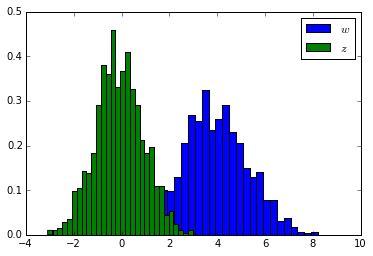

In [10]:
# First the standard normal
z_vec = np.random.normal(size=1000) # by convention, in statistics, z is often used to denote samples from the standard normal
w_vec = z_vec*np.sqrt(alpha) + mu
# plot normalized histogram of w, and then normalized histogram of z on top
plt.hist(w_vec, bins=30, normed=True)
plt.hist(z_vec, bins=30, normed=True)
plt.legend(('$w$', '$z$'))

Now re-run this histogram with 100,000 samples and check that the both histograms look qualitatively Gaussian.

## Sampling from the Prior

Let's use this way of constructing samples from a Gaussian to check what functions look like *a priori*. The process will be as follows. First, we sample a random vector $K$ dimensional from `np.random.normal`. Then we scale it by $\sqrt{\alpha}$ to obtain a prior sample of $\mathbf{w}$.  

In [11]:
K = degree + 1
z_vec = np.random.normal(size=K)
w_sample = z_vec*np.sqrt(alpha)
print w_sample

[ 0.42985377 -0.56292361 -1.34551139  2.13663039  2.187021    3.07513461]


Now we can combine our sample from the prior with the basis functions to create a function,

In [12]:
Phi_pred.shape

(100, 6)

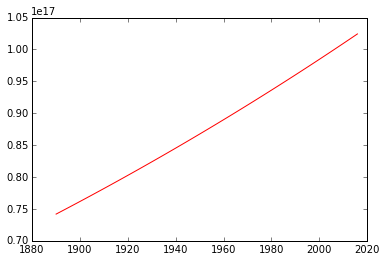

In [13]:
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')

Take a careful look at the scale of this plot on the $y$-axis. This shows the recurring problem with the polynomial basis. Our prior allows relatively large coefficients for the basis associated with high polynomial degrees. Because we are operating with input values of around 2000, this leads to output functions of very high values. One fix for this is to rescale our inputs to be between -1 and 1 before applying the model. This is a disadvantage of the polynomial basis. Let's change our polynomial basis to allow us to scale and offset the inputs.

In [14]:
def polynomial(x, degree, loc, scale):
    degrees = np.arange(degree+1)
    return ((x-loc)/scale)**degrees

scale = np.max(x) - np.min(x) 
loc = np.min(x) + 0.5*scale

Phi = polynomial(x, degree, loc, scale)
Phi_pred = polynomial(x_pred, degree, loc, scale)

Now let's take a look to see if our samples are a little more sensible.

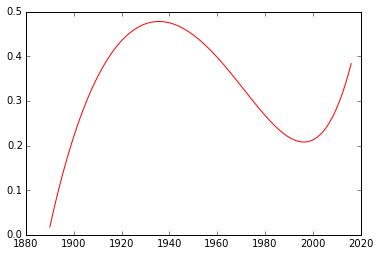

In [15]:
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')

Now let's loop through some samples and plot various functions as samples from this system,

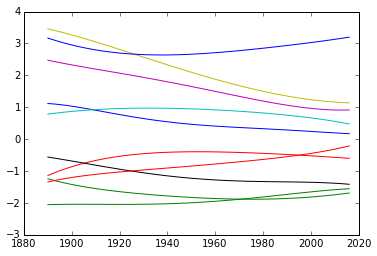

In [18]:
num_samples = 10
K = degree+1
for i in xrange(num_samples):
    z_vec = np.random.normal(size=K)
    w_sample = z_vec*np.sqrt(alpha)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())


The predictions for the mean output can now be computed. We want the expected value of the predictions under the posterior distribution. In matrix form, the predictions can be computed as

$$\mathbf{f} = \boldsymbol{\Phi} \mathbf{w}.$$

This involves a matrix multiplication between a fixed matrix $\boldsymbol{\Phi}$ and a vector that is drawn from a distribution $\mathbf{w}$. Because $\mathbf{w}$ is drawn from a distribution, this imples that $\mathbf{f}$ should also be drawn from a distribution. Let's work out what that distributions should be. 

## Computing the Posterior

In the lecture we went through how to compute the posterior distribution for $\mathbf{w}$. This distribution is also Gaussian,

$$p(\mathbf{w} | \mathbf{y}, \mathbf{x}, \sigma^2) = \mathcal{N}\left(\mathbf{w}|\boldsymbol{\mu}_w, \mathbf{C}_w\right)$$

with covariance, $\mathbf{C}_w$, given by

$$\mathbf{C}_w = \left(\sigma^{-2}\boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \alpha^{-1} \mathbf{I}\right)^{-1}$$ 

whilst the mean is given by

$$\boldsymbol{\mu}_w = \mathbf{C}_w \sigma^{-2}\boldsymbol{\Phi}^\top \mathbf{y}$$

Let's compute the posterior covariance and mean, then we'll sample from these densities to have a look at the posterior belief about $\mathbf{w}$ once the data has been accounted for. Remember, the process of Bayesian inference involves combining the prior, $p(\mathbf{w})$ with the likelihood, $p(\mathbf{y}|\mathbf{x}, \mathbf{w})$ to form the posterior, $p(\mathbf{w} | \mathbf{y}, \mathbf{x})$ through Bayes' rule,

$$p(\mathbf{w}|\mathbf{y}, \mathbf{x}) = \frac{p(\mathbf{y}|\mathbf{x}, \mathbf{w})p(\mathbf{w})}{p(\mathbf{y})}$$

We've looked at the samples for our function $\mathbf{f} = \boldsymbol{\Phi}\mathbf{w}$, which forms the mean of the Gaussian likelihood, under the prior distribution. I.e. we've sampled from $p(\mathbf{w})$ and multiplied the result by the basis matrix. Now we will sample from the posterior density, $p(\mathbf{w}|\mathbf{y}, \mathbf{x})$, and check that the new samples fit do correspond to the data, i.e. we want to check that the updated distribution includes information from the data set. First we need to compute the posterior mean and *covariance*.

In [20]:
# compute the posterior covariance and mean
w_cov = np.linalg.inv(1/sigma2*np.dot(Phi.T, Phi) + 1/alpha*np.eye(degree+1))
w_mean = np.dot(w_cov, 1/sigma2*np.dot(Phi.T, y))

Before we were able to sample the prior values for the mean *independently* from a Gaussian using `np.random.normal` and scaling the result. However, observing the data *correlates* the parameters. Recall this from the first lab where we had a correlation between the offset, $c$ and the slope $m$ which caused such problems with the coordinate ascent algorithm. We need to sample from a *correlated* Gaussian. For this we can use `np.random.multivariate_normal`.

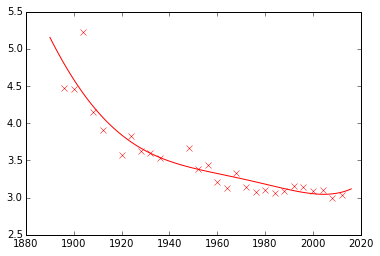

In [21]:
w_sample = np.random.multivariate_normal(w_mean.flatten(), w_cov)
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')
plt.plot(x, y, 'rx') # plot data to show fit.

Now let's sample several functions and plot them all to see how the predictions fluctuate.

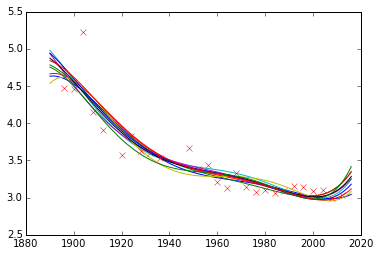

In [22]:
for i in xrange(num_samples):
    w_sample = np.random.multivariate_normal(w_mean.flatten(), w_cov)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())
plt.plot(x, y, 'rx') # plot data to show fit.

### Sum of Gaussian-distributed Variables

The sum of Gaussian random variables is also Gaussian, so if we have a random variable $y_i$ drawn from a Gaussian density with mean $\mu_i$ and variance $\sigma^2_i$, 

$$y_i \sim \mathcal{N}(\mu_i,\sigma^2_i)$$

Then the sum of $k$ independently sampled values of $y_i$ will be drawn from a Gaussian with mean $\sum_{i=1}^k \mu_i$ and variance $\sum_{i=1}^k \sigma_i^2$,


$$\sum_{i=1}^k y_i \sim \mathcal{N}\left(\sum_{i=1}^k \mu_i,\sum_{i=1}^k \sigma_i^2\right).$$

Let's try that experimentally. First let's generate a vector of samples from a standard normal distribution, $z \sim \mathcal{N}(0,1)$,  then we will scale and offset them, then keep adding them into a vector `y_vec`.

In [23]:
K = 10 # how many Gaussians to add.
num_samples = 1000 # how many samples to have in y_vec
mus = np.linspace(0, 5, K) # mean values generated linearly spaced between 0 and 5
sigmas = np.linspace(0.5, 2, K) # sigmas generated linearly spaced between 0.5 and 2
y_vec = np.zeros(num_samples)
for mu, sigma in zip(mus, sigmas):
    z_vec = np.random.normal(size=num_samples) # z is from standard normal
    y_vec += z_vec*sigma + mu # add to y z*sigma + mu

# now y_vec is the sum of each scaled and off set z.
print 'Sample mean is ', y_vec.mean(), ' and sample variance is ', y_vec.var()
print 'True mean should be ', mus.sum()
print 'True variance should be ', (sigmas**2).sum(), ' standard deviation ', np.sqrt((sigmas**2).sum()) 

Sample mean is  25.072752017  and sample variance is  16.8779636428
True mean should be  25.0
True variance should be  17.9166666667  standard deviation  4.2328083664


Of course, we can histogram `y_vec` as well.

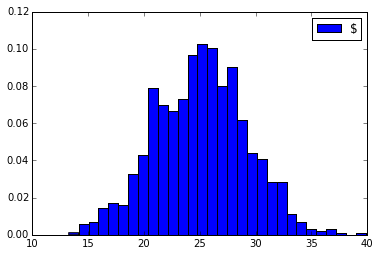

In [24]:
plt.hist(y_vec, bins=30, normed=True)
plt.legend('$y$')

### Matrix Multiplication of Gaussian Variables

Matrix multiplication is just adding and scaling together, in the formula, $\mathbf{f} = \boldsymbol{\Phi} \mathbf{w}$ we can extract the first element from $\mathbf{f}$ as

$$f_i = \boldsymbol{\phi}_i^\top \mathbf{w}$$

where $\boldsymbol{\phi}$ is a column vector from the $i$th row of $\boldsymbol{\Phi}$ and $f_i$ is the $i$th element of $\mathbf{f}$. This vector inner product itself merely implies that 

$$f_i = \sum_{j=1}^K w_j \phi_{i, j}$$

and if we now say that $w_i$ is Gaussian distributed, then because a scaled Gaussian is also Gaussian, and because a sum of Gaussians is also Gaussian, we know that $f_i$ is also Gaussian distributed. It merely remains to work out its mean and covariance. We can do this by looking at the expectation under a Gaussian distribution. The expectation of the mean vector is given by

$$\langle\mathbf{f}\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} = \int \mathbf{f} \mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C}) \text{d}\mathbf{w} = \int \boldsymbol{\Phi}\mathbf{w} \mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C}) \text{d}\mathbf{w} = \boldsymbol{\Phi} \int \mathbf{w} \mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C}) \text{d}\mathbf{w} = \boldsymbol{\Phi} \boldsymbol{\mu}$$

Which is straightforward. The expectation of $\mathbf{f}=\boldsymbol{\Phi}\mathbf{w}$ under the Gaussian distribution for $\mathbf{f}$ is simply $\mathbf{f}=\boldsymbol{\Phi}\boldsymbol{\mu}$, where $\boldsymbol{\mu}$ is the *mean* of the Gaussian density for $\mathbf{w}$. Because our prior distribution was Gaussian with zero mean, the expectation under the prior is given by

$$\langle\mathbf{f}\rangle_{\mathcal{N}(\mathbf{w}|\mathbf{0},\alpha\mathbf{I}}) = \mathbf{0}$$

The covariance is a little more complicated. A covariance matrix is defined as

$$\text{cov}\left(\mathbf{f}\right)_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} = \langle\mathbf{f}\mathbf{f}^\top\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} - \langle\mathbf{f}\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})}\langle\mathbf{f}\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})}^\top$$

we've already computed $\langle\mathbf{f}\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})}=\boldsymbol{\Phi} \boldsymbol{\mu}$ so we can substitute that in to recover

$$\text{cov}\left(\mathbf{f}\right)_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} = \langle\mathbf{f}\mathbf{f}^\top\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} - \boldsymbol{\Phi} \boldsymbol{\mu} \boldsymbol{\mu}^\top \boldsymbol{\Phi}^\top$$

So we need the expectation of $\mathbf{f}\mathbf{f}^\top$. Substituting in $\mathbf{f} = \boldsymbol{\Phi} \mathbf{w}$ we have

$$\text{cov}\left(\mathbf{f}\right)_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} = \langle\boldsymbol{\Phi}\mathbf{w}\mathbf{w}^\top \boldsymbol{\Phi}^\top\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} - \boldsymbol{\Phi} \boldsymbol{\mu} \boldsymbol{\mu}^\top \boldsymbol{\Phi}^\top$$

$$\text{cov}\left(\mathbf{f}\right)_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} = \boldsymbol{\Phi}\langle\mathbf{w}\mathbf{w}^\top\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} \boldsymbol{\Phi}^\top - \boldsymbol{\Phi} \boldsymbol{\mu} \boldsymbol{\mu}^\top \boldsymbol{\Phi}^\top$$

Which is dependent on the second moment of the Gaussian,

$$\langle\mathbf{w}\mathbf{w}^\top\rangle_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} = \mathbf{C} + \boldsymbol{\mu}\boldsymbol{\mu}^\top$$

that can be substituted in to recover,

$$\text{cov}\left(\mathbf{f}\right)_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} = \boldsymbol{\Phi}\mathbf{C} \boldsymbol{\Phi}^\top$$

so in the case of the prior distribution, where we have $\mathbf{C} = \alpha \mathbf{I}$ we can write

$$\text{cov}\left(\mathbf{f}\right)_{\mathcal{N}(\mathbf{w}|\mathbf{0},\alpha \mathbf{I})} = \alpha \boldsymbol{\Phi} \boldsymbol{\Phi}^\top$$

This implies that the prior we have suggested for $\mathbf{w}$, which is Gaussian with a mean of zero and covariance of $\alpha \mathbf{I}$ suggests that the distribution for $\mathbf{w}$ is also Gaussian with a mean of zero and covariance of $\alpha \boldsymbol{\Phi}\boldsymbol{\Phi}^\top$. Since our observed output, $\mathbf{y}$, is given by a noise corrupted variation of $\mathbf{f}$, the final distribution for $\mathbf{y}$ is given as 

$$\mathbf{y} = \mathbf{f} + \boldsymbol{\epsilon}$$

where the noise, $\boldsymbol{\epsilon}$, is sampled from a Gaussian density: $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0},\sigma^2\mathbf{I})$. So, in other words, we are taking a Gaussian distributed random value $\mathbf{f}$,

$$\mathbf{f} \sim \mathcal{N}(\mathbf{0},\alpha\boldsymbol{\Phi}\boldsymbol{\Phi}^\top)$$

and adding to it another Gaussian distributed value, $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0},\sigma^2\mathbf{I})$, to form our data observations, $\mathbf{y}$. Once again the sum of two (multivariate) Gaussian distributed variables is also Gaussian, with a mean given by the sum of the means (both zero in this case) and the covariance given by the sum of the covariances. So we now have that the marginal likelihood for the data, $p(\mathbf{y})$ is given by

$$p(\mathbf{y}) = \mathcal{N}(\mathbf{y}|\mathbf{0},\alpha \boldsymbol{\Phi} \boldsymbol{\Phi}^\top + \sigma^2\mathbf{I})$$

This is our *implicit* assumption for $\mathbf{y}$ given our prior assumption for $\mathbf{w}$.

### Computing the Mean and Error Bars of the Functions

You should now know enough to compute the mean of the predictions under the posterior density. 

In [25]:
# compute mean under posterior density
f_pred_mean = np.dot(Phi_pred, w_mean)

We can plot these predictions alongside the real data,

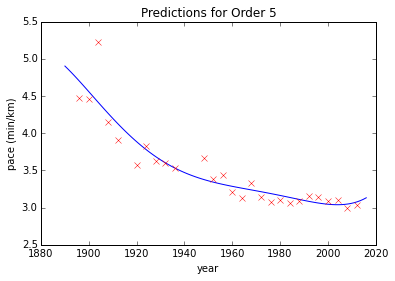

In [27]:
# print the error and plot the predictions
plt.plot(x_pred, f_pred_mean)
plt.plot(x, y, 'rx')
ax = plt.gca()
ax.set_title('Predictions for Order ' + str(degree))
ax.set_xlabel('year')
ax.set_ylabel('pace (min/km)')

### Computing the Error

We can also compute what the training error was. First compute the expected output under the posterior density,

In [28]:
f_mean = np.dot(Phi, w_mean)

These can be used to compute the error

$$E(\mathbf{w}) =  \frac{n}{2} \log \sigma^2 + \frac{1}{2\sigma^2} \sum_{i=1}^n \left(y_i - \mathbf{w}^\top \phi(\mathbf{x}_i)\right)^2 \\\
E(\mathbf{w}) = \frac{n}{2} \log \sigma^2 + \frac{1}{2\sigma^2} \sum_{i=1}^n \left(y_i - f_i\right)^2$$

In [29]:
# compute the sum of squares term
sum_squares = ((y-f_mean)**2).sum()
# fit the noise variance
error = (num_data/2*np.log(sigma2) + sum_squares/(2*sigma2))
print 'The error is: ',error

The error is:  -6.26873167309


Now we have the fit and the error, let's plot the fit and the error.

### Computing Error Bars

Finally, we can compute error bars for the predictions. The error bars are the standard deviations of the predictions for $\mathbf{f}=\boldsymbol{\Phi}\mathbf{w}$ under the posterior density for $\mathbf{w}$. The standard deviations of these predictions can be found from the variance of the prediction at each point. Those variances are the diagonal entries of the covariance matrix. We've already computed the form of the covariance under Gaussian expectations, 

$$\text{cov}\left(\mathbf{f}\right)_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu},\mathbf{C})} = \boldsymbol{\Phi}\mathbf{C} \boldsymbol{\Phi}^\top$$

which under the posterior density is given by

$$\text{cov}\left(\mathbf{f}\right)_{\mathcal{N}(\mathbf{w}|\boldsymbol{\mu}_w,\mathbf{C}_w}) = \boldsymbol{\Phi}\mathbf{C}_w \boldsymbol{\Phi}^\top$$

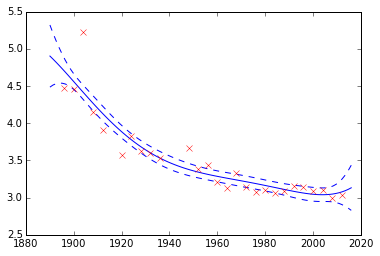

In [30]:
# compute the error bars
f_pred_cov = np.dot(Phi_pred, np.dot(w_cov, Phi_pred.T))
f_pred_var = np.diag(f_pred_cov)[:, None]
f_pred_std = np.sqrt(f_pred_var)

# plot mean, and error bars at 2 standard deviations
plt.plot(x_pred.flatten(), f_pred_mean.flatten(), 'b-')
plt.plot(x_pred.flatten(), (f_pred_mean+2*f_pred_std).flatten(), 'b--')
plt.plot(x_pred.flatten(), (f_pred_mean-2*f_pred_std).flatten(), 'b--')
plt.plot(x, y, 'rx')